# RNN

In [ ]:
import torch
import string
import unicodedata
from io import open
import glob
import os
import time
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## NN VS RNN

<!-- ![alt text](<utils/images/feed forward vs rnn.png>) -->

![alt text](<utils/images/feed forward vs rnn.png>)

![alt text](<utils/images/unrolling rnn.png>)

## DATA PREPARATION

In [24]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


### Data cleaning

In [25]:
# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

### Turning names into tensors

In [26]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

### Dataset

In [27]:
class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [38]:
alldata = NamesDataset(data_dir=r"C:\Users\Hyperbook\Desktop\STUDIA\SEM III\Projekt zespolowy\utils\datasets\data\names")
alldata.data_dir
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([2], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0.,

### Train and test split

In [39]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


## RNN IMPLEMENTATION

### RNN LAYER (forward demonstration only)

In [ ]:
# Efficient implementation equivalent to the following with bidirectional=False
def forward(x, hx=None):
    if batch_first:
        x = x.transpose(0, 1)
    seq_len, batch_size, _ = x.size()
    # stan ukryty inicjalizacja jesli go nie ma - zera dla kazdej warstwy
    if hx is None:
        hx = torch.zeros(num_layers, batch_size, hidden_size)
    # stan ukryty ze stanu poprzedniego
    h_t_minus_1 = hx
    h_t = hx
    output = []
    for t in range(seq_len):
        for layer in range(num_layers):
            # nowy stan ukryty
            h_t[layer] = torch.tanh(
                x[t] @ weight_ih[layer].T # projekcja wejscia x[t] przez wagi wejsciowe
                + bias_ih[layer]
                + h_t_minus_1[layer] @ weight_hh[layer].T # projekcja poprzedniego stanu ukrytego dla tej warstwy
                + bias_hh[layer]
            )
        output.append(h_t[-1])
        # aktualizacja
        h_t_minus_1 = h_t
    output = torch.stack(output)
    if batch_first:
        output = output.transpose(0, 1)
    return output, h_t

![alt text](<unrolling lstm-1.png>)

![alt text](<utils/images/rnn cell.png>)

### RNN NETWORK

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [ ]:
n_hidden = 128
RNN = RNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(RNN)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = RNN(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.8421, -3.0173, -2.9071, -2.8819, -2.9950, -2.8664, -2.9722, -2.8733,
         -2.6914, -2.7968, -2.9176, -2.9273, -2.8982, -2.9947, -2.9685, -2.9483,
         -2.7919, -2.8005]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Scottish', 8)


### TRAINING

In [46]:
def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    # NLLLoss to Negative Log Likelihood Loss
    # uzywana dlatego ze przewidujemy jedna z wielu klas
    # im log(a) blizej 0 tym lepiej
    
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [ ]:
all_losses = train(RNN, train_set, n_epoch=27, learning_rate=0.15, report_every=5)


training on data set with n = 17063
5 (19%): 	 average batch loss = 0.8843707551357718
10 (37%): 	 average batch loss = 0.6871766994477284
15 (56%): 	 average batch loss = 0.5678555823435942
20 (74%): 	 average batch loss = 0.4882586438896134
25 (93%): 	 average batch loss = 0.42617969119510873


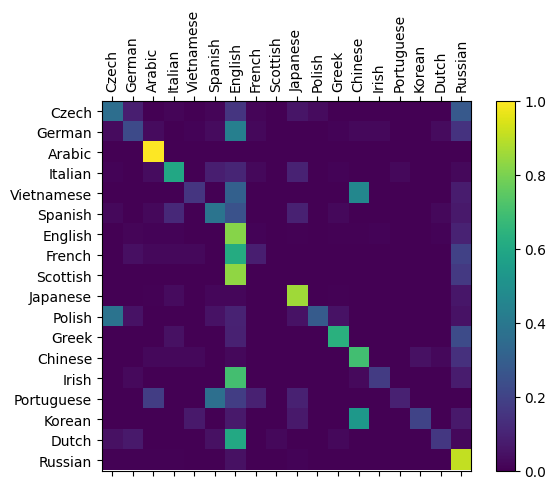

In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(RNN, test_set, classes=alldata.labels_uniq)

## LINKS

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial <p></p> https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo?tab=readme-ov-file#whatisRNN

In [1]:
import mido

# Load a MIDI file
mid = mido.MidiFile('your_file.mid')

# Print basic info
print(f"Type: {mid.type}, Ticks per beat: {mid.ticks_per_beat}, Tracks: {len(mid.tracks)}")

# Iterate over messages
for i, track in enumerate(mid.tracks):
    print(f'\nTrack {i}: {track.name}')
    for msg in track:
        print(msg)



ModuleNotFoundError: No module named 'mido'